## How to do it...

1. Import libraries

In [1]:
import imageio
import numpy as np
from skimage.transform import resize
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display
import PIL.Image

2. Declare image locations

In [2]:
content_image_file = 'maria.jpg'
style_image_file = 'starry_night.jpg'

3. Load imaege and fit dimensions

In [3]:
# Read the images
content_image = imageio.imread(content_image_file)
style_image = imageio.imread(style_image_file)
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

# Get shape of target and make the style image the same
target_shape = content_image.shape
style_image = resize(style_image, target_shape)

4. Display images

Text(0.5, 1.0, 'Style Image')

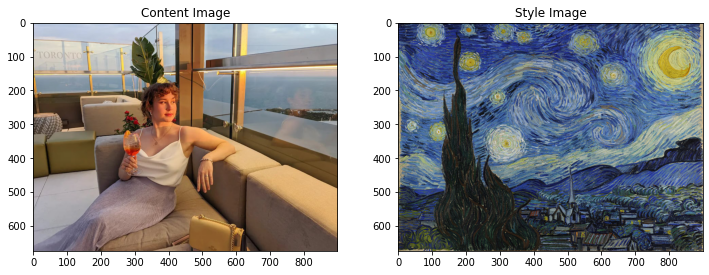

In [4]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("Style Image")

5. Load VGG-19 model pretrained on ImageNet without classification head

In [5]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

6. Display VGG-19 architecture

In [6]:
[layer.name for layer in vgg.layers]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

7. Assign intermediate layers as style and content

In [7]:
content_layers = ['block4_conv2', 'block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

8. Define Gram matrix to capture style of image

In [8]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

9. Build a model that returns style and content dictionaries

In [9]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        
        self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        
        outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
        self.vgg = tf.keras.Model([vgg.input], outputs)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        "Expects float input in [0, 1]"
        inputs = inputs*255.0
        inputs = inputs[tf.newaxis, :]
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                         outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    
        return {'content': content_dict, 'style': style_dict}

10. Set style and content target values

In [10]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

11. Set optimizer and hyperparameters

In [11]:
# Optimizer configuration
learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999

opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)

12. Compute total loss

In [12]:
# Choose weighting
content_weight = 5.0
style_weight = 1.0

# Define loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs= outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

13. Declare utility function

In [13]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

14. Declare second utility function

In [14]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

16. Run gradient descent, generate new image, display it

Epoch 10 of 50 complete.
Epoch 20 of 50 complete.
Epoch 30 of 50 complete.
Epoch 40 of 50 complete.
Epoch 50 of 50 complete.


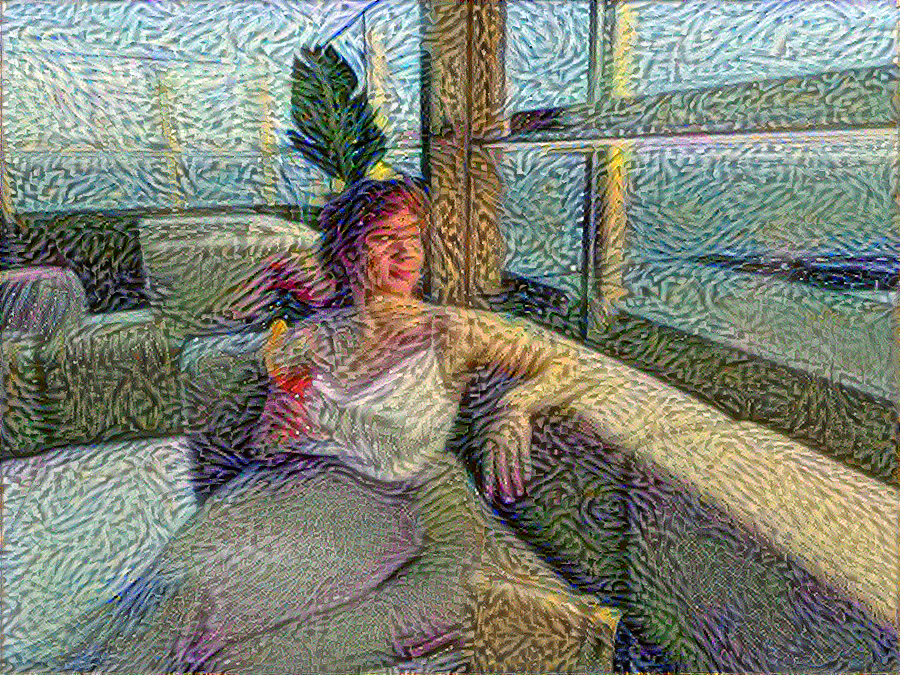

In [15]:
epochs = 50

image = tf.Variable(content_image)

for generation in range(epochs):
    
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([[grad, image]])
    image.assign(clip_0_1(image))
    if (generation+1) % 10 == 0:
        print(f'Epoch {generation+1} of {epochs} complete.')
    
display.display(tensor_to_image(image))